In [51]:
# 0) Preparación
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

np.random.seed(42)
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')

In [52]:
# 1) Datos simulados (1000 personas)
n = 1000
df = pd.DataFrame({
    'edad': np.random.randint(18, 65, n),
    'ingreso_mensual': np.random.normal(15000, 5000, n).clip(5000, 30000),
    'tiempo_transporte': np.random.normal(45, 15, n).clip(10, 120),
    'gasto_mensual_transporte': np.random.normal(1200, 400, n).clip(300, 3000),
    'nivel_satisfaccion': np.random.randint(1, 11, n),          # 1–10
    'frecuencia_ciclovia': np.random.randint(0, 6, n),           # veces/semana
    'percepcion_contaminacion': np.random.randint(1, 11, n)      # 1–10
})
df.head()

,edad,ingreso_mensual,tiempo_transporte,gasto_mensual_transporte,nivel_satisfaccion,frecuencia_ciclovia,percepcion_contaminacion
0,56,"20,031.46",27.45,701.71,8,5,2
1,46,"12,115.54",10.00,"1,221.97",3,4,3
2,32,"19,178.46",44.59,916.17,10,3,10
3,60,"9,351.47",71.58,696.60,7,3,2
4,25,"17,649.02",69.92,"1,113.19",2,4,3


In [ ]:
# Guaramos la base de datos original en csv
df.to_csv('PoliticaPublica.csv', index=False)
#Cargamos la base de datos
df = pd.read_csv('PoliticaPublica.csv')


In [62]:
# 2.1 Resumen rápido
df.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
edad,"1,000.00",40.99,13.50,18.00,29.00,42.00,52.00,64.00
ingreso_mensual,"1,000.00","15,445.61","4,903.50","5,000.00","12,129.08","15,382.07","18,572.44","28,161.91"
tiempo_transporte,"1,000.00",45.29,14.49,10.00,35.37,45.06,55.11,92.90
gasto_mensual_transporte,"1,000.00","1,200.98",406.29,300.00,916.21,"1,192.48","1,471.60","2,770.50"
nivel_satisfaccion,"1,000.00",5.58,2.93,1.00,3.00,6.00,8.00,10.00
frecuencia_ciclovia,"1,000.00",2.47,1.70,0.00,1.00,2.00,4.00,5.00
percepcion_contaminacion,"1,000.00",5.52,2.89,1.00,3.00,6.00,8.00,10.00


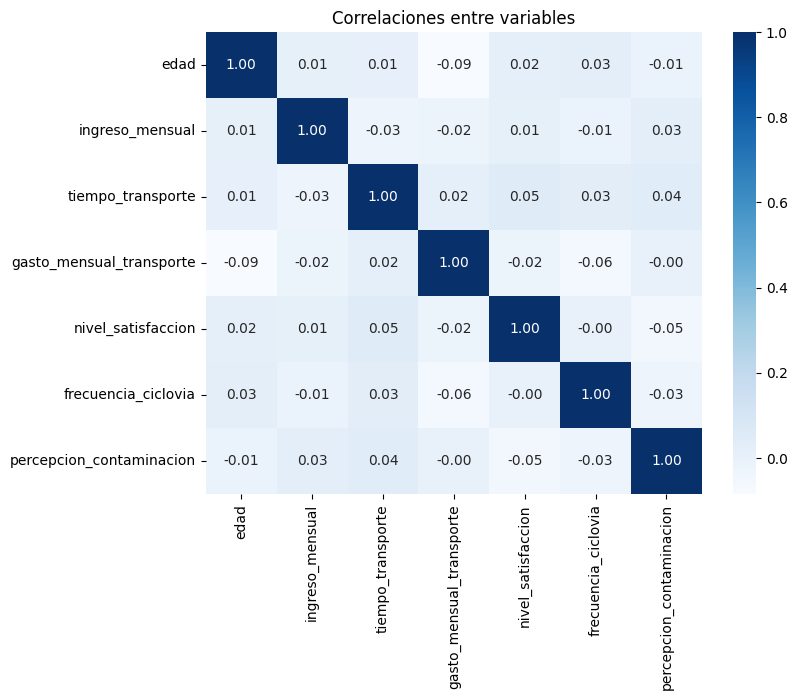

In [53]:
# 2.1 Resumen rápido
df.describe()

# 2.2 Matriz de correlaciones
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt='.2f', cmap='Blues')
plt.title('Correlaciones entre variables')
plt.show()

In [54]:
# 3) Escalar variables numéricas
features = df.columns  # en este ejemplo, todas son numéricas
scaler = StandardScaler()
X = scaler.fit_transform(df[features])

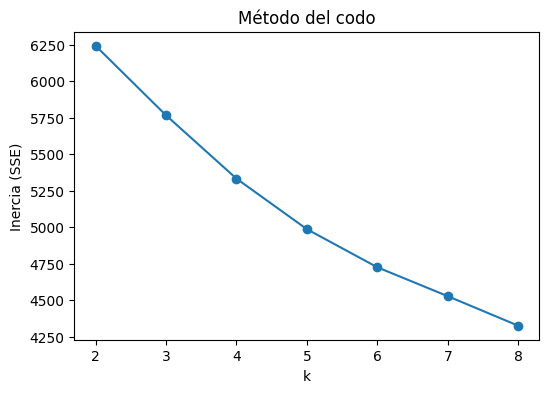

{2: np.float64(0.10700623907653647),
 3: np.float64(0.09824526231332947),
 4: np.float64(0.10587240586222862),
 5: np.float64(0.1116887322085235),
 6: np.float64(0.11234976179297498),
 7: np.float64(0.11358768829000485),
 8: np.float64(0.11459150642915063)}

In [55]:
# 4.1 Método del codo
inertias = []
K_range = range(2, 9)
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init='auto')
    km.fit(X)
    inertias.append(km.inertia_)

plt.figure(figsize=(6,4))
plt.plot(list(K_range), inertias, marker='o')
plt.xlabel('k')
plt.ylabel('Inercia (SSE)')
plt.title('Método del codo')
plt.show()

# 4.2 Silueta por cada k
sil_vals = {}
for k in K_range:
    labels = KMeans(n_clusters=k, random_state=42, n_init='auto').fit_predict(X)
    sil = silhouette_score(X, labels)
    sil_vals[k] = sil

sil_vals

In [ ]:
# 5) Ajuste final (elige k con tu criterio: codo + silueta + interpretabilidad)
k_elegido = 5  # <- AJUSTAR según lo encontrado
kmeans = KMeans(n_clusters=k_elegido, random_state=42, n_init='auto')
clusters = kmeans.fit_predict(X)

df_clusters = df.copy()
df_clusters['cluster'] = clusters

sil = silhouette_score(X, clusters)
print(f'Coeficiente de silueta (k={k_elegido}): {sil:.3f}')
df_clusters.head()

Coeficiente de silueta (k=3): 0.098


,edad,ingreso_mensual,tiempo_transporte,gasto_mensual_transporte,nivel_satisfaccion,frecuencia_ciclovia,percepcion_contaminacion,cluster
0,56,"20,031.46",27.45,701.71,8,5,2,0
1,46,"12,115.54",10.00,"1,221.97",3,4,3,0
2,32,"19,178.46",44.59,916.17,10,3,10,1
3,60,"9,351.47",71.58,696.60,7,3,2,0
4,25,"17,649.02",69.92,"1,113.19",2,4,3,2


In [57]:
# 6.1 Promedios por clúster (en escala original)
resumen = df_clusters.groupby('cluster').agg(['mean','median']).round(2)
resumen

edad        ingreso_mensual           tiempo_transporte         \
         mean median            mean    median              mean median   
cluster                                                                   
0       51.98  53.00       15,986.81 15,652.69             45.16  45.54   
1       32.44  31.00       15,383.15 15,411.42             44.92  44.59   
2       39.34  39.00       14,990.61 15,092.09             45.82  45.10   

        gasto_mensual_transporte          nivel_satisfaccion         \
                            mean   median               mean median   
cluster                                                               
0                       1,088.92 1,073.03               5.68   6.00   
1                       1,361.64 1,360.19               7.81   8.00   
2                       1,141.24 1,129.77               3.14   3.00   

        frecuencia_ciclovia        percepcion_contaminacion         
                       mean median                     mean median  
cluster                                                             
0                      2.48   2.00                     3.37   3.00  
1                      2.56   3.00                     5.52   6.00  
2                      2.38   2.00                     7.60   8.00

In [58]:
# 6.2 Centros del modelo (reconvertidos a escala original)
centros_scaled = kmeans.cluster_centers_
centros_original = pd.DataFrame(
    scaler.inverse_transform(centros_scaled),
    columns=features
).round(2)
centros_original.index.name = 'cluster'
centros_original

,edad,ingreso_mensual,tiempo_transporte,gasto_mensual_transporte,nivel_satisfaccion,frecuencia_ciclovia,percepcion_contaminacion
cluster,,,,,,,
0,51.97,"15,986.81",45.16,"1,088.92",5.68,2.48,3.37
1,32.44,"15,383.15",44.92,"1,361.64",7.81,2.56,5.52
2,39.34,"14,990.61",45.82,"1,141.24",3.14,2.38,7.60


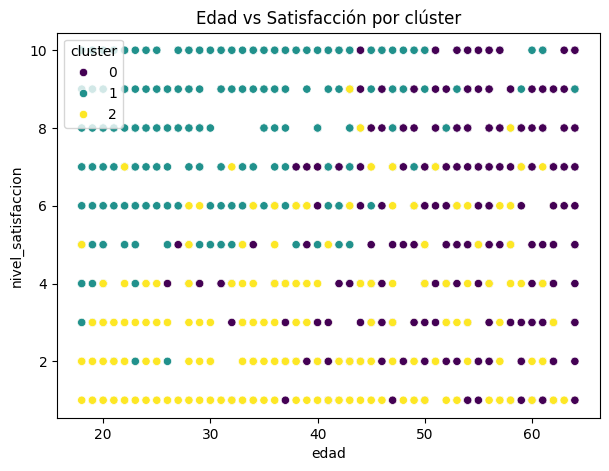

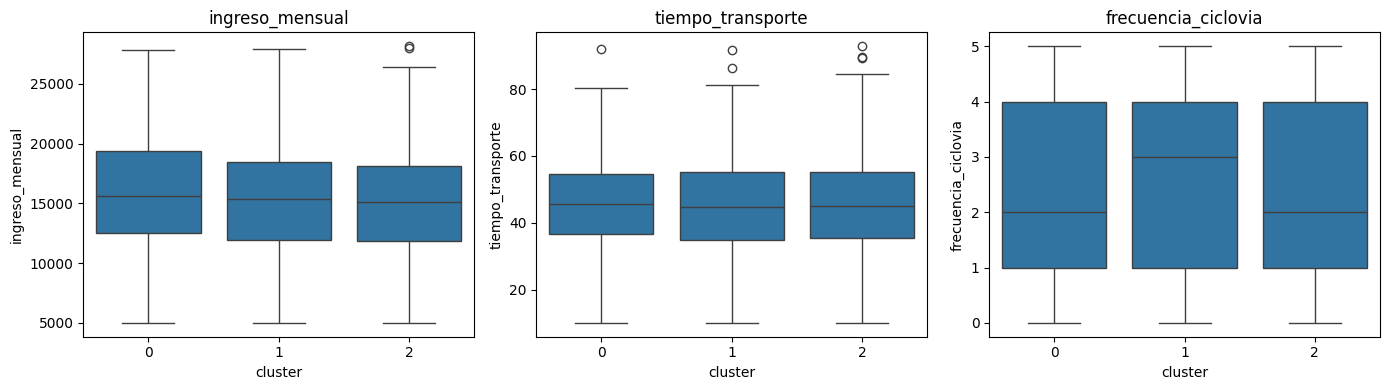

In [59]:
# 7.1 Dispersión edad vs satisfacción
plt.figure(figsize=(7,5))
sns.scatterplot(
    data=df_clusters,
    x='edad', y='nivel_satisfaccion',
    hue='cluster', palette='viridis'
)
plt.title('Edad vs Satisfacción por clúster')
plt.show()

# 7.2 Boxplots comparativos por clúster (ejemplo con 3 variables clave)
vars_clave = ['ingreso_mensual', 'tiempo_transporte', 'frecuencia_ciclovia']
fig, axes = plt.subplots(1, len(vars_clave), figsize=(14,4))
for i, col in enumerate(vars_clave):
    sns.boxplot(data=df_clusters, x='cluster', y=col, ax=axes[i])
    axes[i].set_title(col)
plt.tight_layout()
plt.show()

In [63]:
# 9.1 Cambiar semilla y comparar silueta
def entrenar_con_semilla(seed, k):
    km = KMeans(n_clusters=k, random_state=seed, n_init='auto')
    labs = km.fit_predict(X)
    return silhouette_score(X, labs)

semillas = [0, 7, 42, 100]
for s in semillas:
    print(f'Semilla {s}: silueta = {entrenar_con_semilla(s, k_elegido):.3f}')

Semilla 0: silueta = 0.093
Semilla 7: silueta = 0.095
Semilla 42: silueta = 0.098
Semilla 100: silueta = 0.094


In [64]:
# 9.2 Probar otro k cercano y discutir (p.ej., k+1)
for k in [k_elegido-1, k_elegido, k_elegido+1]:
    if k >= 2:
        labs = KMeans(n_clusters=k, random_state=42, n_init='auto').fit_predict(X)
        print(f'k={k}: silueta = {silhouette_score(X, labs):.3f}')

k=2: silueta = 0.107
k=3: silueta = 0.098
k=4: silueta = 0.106
